In [3]:
#Numerical integration of Eqs. (11) to produce the results in Figs. 5 and 6
#The first cell performs the integration, the second plots the results

import matplotlib.pyplot as plt
import numpy as np
import math
import multiprocessing
from multiprocessing import Pool
import csv
from numpy import linalg as la
from scipy.stats import kde
from scipy.fftpack import fft, ifft
#from IPython import get_ipython;  
#import itertools 
#get_ipython().magic('reset -sf')
#plt.close('all')

#model parameters
complexity = 0.02
n = 100
c = 1.0
sigma = np.sqrt(complexity/(float(n)*float(c)))
nx = int(0.5*float(n))
ny = int(0.5*float(n))
dx = 0.1
dy = 0.1
ncmuxx = 1.2
muxx = ncmuxx/(float(n)*float(c))
ncmuxy = -2.0
muxy = ncmuxy/(float(n)*float(c))
ncmuyx = 2.0
muyx = ncmuyx/(float(n)*float(c))
ncmuyy = -0.8
muyy = ncmuyy/(float(n)*float(c))
b = 0.5
gammax = 0.5
gammay = -0.5
gammaxy = 0.0


meanxy = [muxy,muyx]
covxy = [[sigma**2.0, sigma**2.0*gammaxy], [sigma**2.0*gammaxy, sigma**2.0]]
meanxx = [muxx,muxx]
covxx = [[sigma**2.0, sigma**2.0*gammax], [sigma**2.0*gammax, sigma**2.0]]
meanyy = [muyy,muyy]
covyy = [[sigma**2.0, sigma**2.0*gammay], [sigma**2.0*gammay, sigma**2.0]]

#Dispersal rates

Dy = 20.0
Dx = 0.2
'''
Dy = 0.0
Dx = 0.0
'''
sigma0 = 0.1
x0 = 1.0
y0 = 1.0


dt = 0.01
dteff = 0.01
tmax = 250.0
tmin = 0.0
tsamp = 0.0
numstep = int((tmax - tmin)/dt) +1
numstepeff = int((tmax - tmin)/dteff) +1
numsample = 1001
numpos = 101




if __name__ == '__main__':


	print("Example trajectory...")

	
	np.random.seed(0 )
	Jxx = np.zeros((nx,nx))
	Jxy = np.zeros((nx,ny))
	Jyx = np.zeros((ny,nx))
	Jyy = np.zeros((ny,ny))

	#set up discrete Laplacian operator
	laplacian = np.zeros((numpos, numpos))
	laplacian[0][numpos-1] = 1.0
	laplacian[numpos-1][0] = 1.0
	for i in range(0,numpos):
		laplacian[i][i] = -2.0
		if(i != 0):
			laplacian[i][i-1] = 1.0
		if(i != numpos-1):
			laplacian[i][i+1] = 1.0
		
	#construct random interaction matrix
	for i in range(0,nx):
		for k in range(0,ny):
			Jxy[i][k], Jyx[k][i] = np.random.multivariate_normal(meanxy,covxy)

	for i in range(0,nx):
		for k in range(0,i):
			Jxx[i][k], Jxx[k][i] = np.random.multivariate_normal(meanxx,covxx)

	for i in range(0,ny):
		for k in range(0,i):
			Jyy[i][k], Jyy[k][i] = np.random.multivariate_normal(meanyy,covyy)

	
	xsamp = np.ones((nx, numpos, numsample))
	ysamp = np.ones((ny, numpos, numsample))

	#Initial condition
	x = np.zeros((nx, numpos))
	y = np.zeros((ny, numpos))

	for i in range(0, nx):
		for j in range(0,numpos):
			x[i][j] = x0
	for i in range(0, ny):
		for j in range(0,numpos):
			y[i][j] = y0

	x[0][int((numpos -1)/4)] = 2.0*x0

	step = 0
	t = 0
	#Numerical integration
	while t <= tmax + dt:
		#sampling the trajectories
		if step % int((numstep-1)/(numsample - 1)) == 0:		
			for i in range(0,nx):
				for j in range(0, numpos):
					xsamp[i][j][int(step*(float(numsample-1)/float(numstep - 1)))] = x[i][j]

			for i in range(0,ny):
				for j in range(0, numpos):
					ysamp[i][j][int(step*(float(numsample-1)/float(numstep - 1)))] = y[i][j]


		#RK4 method	
		k1x = dt*(Dx*(laplacian.dot(x.T)).T + x*(b -dx*x + Jxx.dot(x) + Jxy.dot(y)))
		k1y = dt*(Dy*(laplacian.dot(y.T)).T + y*(-dy*y + Jyx.dot(x) + Jyy.dot(y)))
		x1 = x + 0.5*k1x
		y1 = y + 0.5*k1y
		k2x = dt*(Dx*(laplacian.dot(x1.T)).T + x1*(b -dx*x1 + Jxx.dot(x1) + Jxy.dot(y1)))
		k2y = dt*(Dy*(laplacian.dot(y1.T)).T + y1*(-dy*y1 + Jyx.dot(x1) + Jyy.dot(y1)))	
		x2 = x + 0.5*k2x
		y2 = y + 0.5*k2y
		k3x = dt*(Dx*(laplacian.dot(x2.T)).T + x2*(b -dx*x2 + Jxx.dot(x2) + Jxy.dot(y2)))
		k3y = dt*(Dy*(laplacian.dot(y2.T)).T + y2*(-dy*y2 + Jyx.dot(x2) + Jyy.dot(y2)))	
		x3 = x + k3x
		y3 = y + k3y
		k4x = dt*(Dx*(laplacian.dot(x3.T)).T + x3*(b -dx*x3 + Jxx.dot(x3) + Jxy.dot(y3)))
		k4y = dt*(Dy*(laplacian.dot(y3.T)).T + y3*(-dy*y3 + Jyx.dot(x3) + Jyy.dot(y3)))
		x = x + 1.0/6.0*(k1x + 2.0*k2x + 2.0*k3x + k4x)
		y = y + 1.0/6.0*(k1y + 2.0*k2y + 2.0*k3y + k4y)

		step = step +1
		t = t + dt
		


	print("Results ready for plotting...")









Example trajectory...
Results ready for plotting...


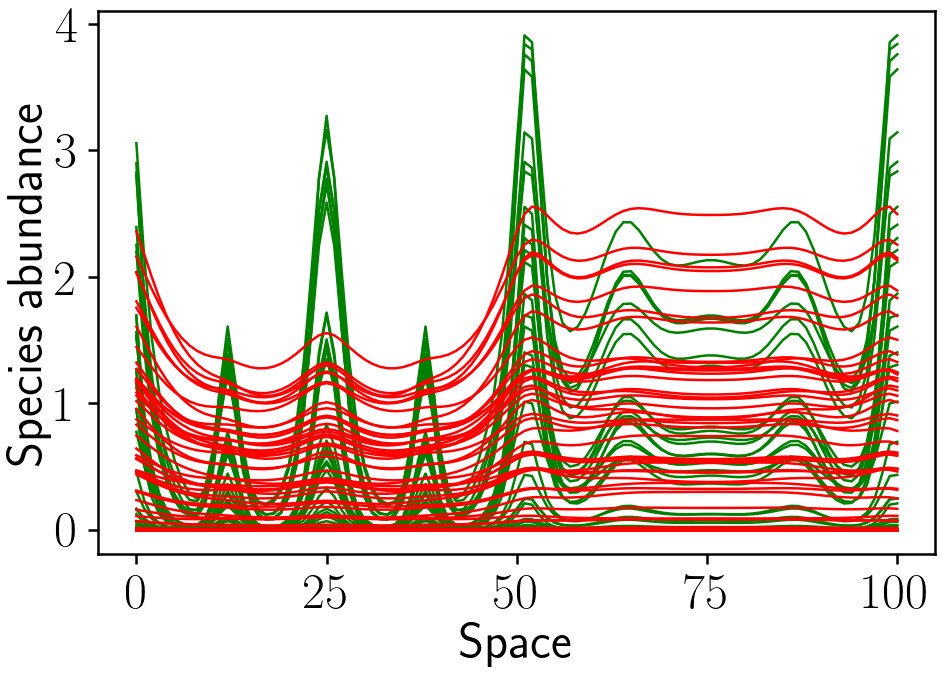

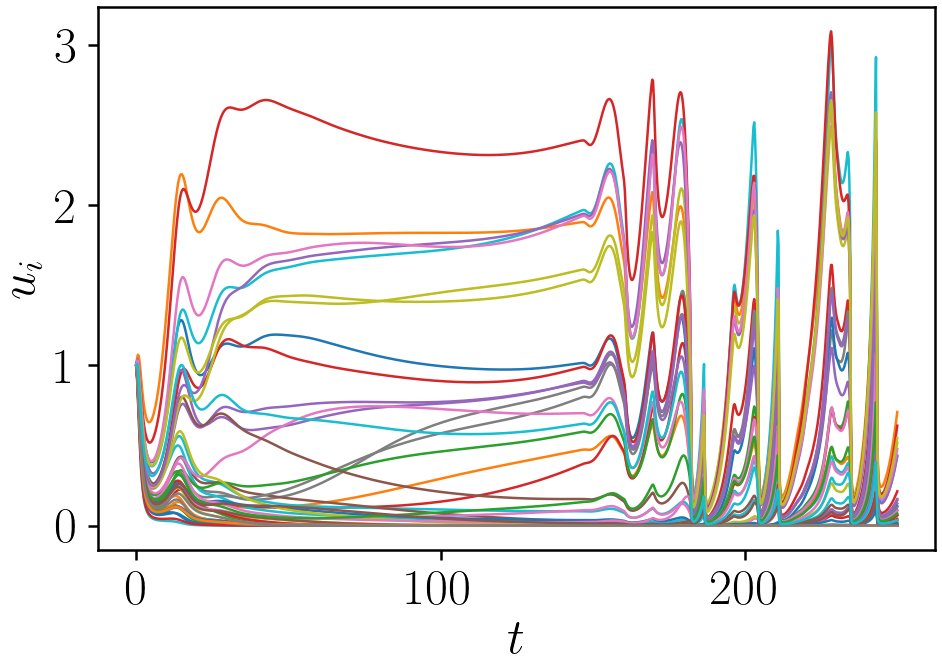

In [4]:
	#plotting the results...
	t = np.linspace(tmin,tmax,numsample, endpoint=True)
	pos = np.linspace(0,numpos-1,numpos, endpoint=True)
	teff = np.linspace(tmin,tmax,numstepeff, endpoint=True)

	#Plot properties
	SIZE = 50
	plt.rc('font', size=SIZE)          # controls default text sizes
	plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
	plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
	plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
	plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
	plt.rc('legend', fontsize=SIZE-10)    # legend fontsize
	plt.rc('text', usetex=True)
	plt.rcParams['axes.linewidth'] = 2.5
	plt.rcParams['legend.loc'] = 'best'
	edgewidth = 3
	lwidth = 2.5
	size = 15
	tickwidth = 2.5
	ticklength = 10
	padness = 10
	fsize = 10

	#Calculate mean and variance of species abundances
	meanx = np.zeros((numpos,numsample))
	meany = np.zeros((numpos,numsample))
	meanxy = np.zeros((numpos,numsample))
	varx = np.zeros((numpos,numsample))
	vary = np.zeros((numpos,numsample))
	varxy = np.zeros((numpos,numsample))

	for i in range(0,nx):
		 meanx = meanx + xsamp[i]/float(nx)
		 meanxy = meanxy + xsamp[i]/float(nx+ny)

	for i in range(0,ny):
		 meany = meany + ysamp[i]/float(ny)
		 meanxy = meanxy + ysamp[i]/float(nx+ny)

	for i in range(0,nx):
		 varx = varx + (xsamp[i]-meanx)**2.0/float(nx)
		 varxy = varxy + (xsamp[i]-meanxy)**2.0/float(nx+ny)

	for i in range(0,ny):
		 vary = vary + (ysamp[i]-meany)**2.0/float(ny)
		 varxy = varxy + (ysamp[i]-meanxy)**2.0/float(nx+ny)
	'''
	#Plot means
	#plt.close('all')
	fig1 = plt.figure(figsize=(15,10))
	ax1 = fig1.add_subplot(111)
	#for i in range(0,nx):
		#ax1.plot(t, xsamp[i][1], '-', linewidth = lwidth)
	ax1.plot(t, meanx[1], '-', color = 'g', linewidth = lwidth)
	ax1.plot(t, meany[1], '-', color = 'r', linewidth = lwidth)
	ax1.plot(t, meanxy[1], '-', color = 'b', linewidth = lwidth)
	axes = plt.gca()
	#axes.set_xlim([xmin,xmax])
	#axes.set_ylim([0,max(hist[0]/float(numtrial))])
	ax1.set_ylabel(r"Mean species abundance", rotation = 90)
	ax1.set_xlabel(r"Time")
	#ax1.legend()
	ax1.tick_params(width = tickwidth, length = ticklength)
	ax1.tick_params(pad=padness)
	#ax1.text(0.8, 0.15, r"(a)", transform=ax1.transAxes, fontsize=fsize,
       		#verticalalignment='top', bbox=props, color='black')
	fig1.show()


	#Plot variances in species abundance
	fig1 = plt.figure(figsize=(15,10))
	ax1 = fig1.add_subplot(111)
	ax1.plot(t, varx[1], '-', color = 'g', linewidth = lwidth)
	ax1.plot(t, vary[1], '-', color = 'r', linewidth = lwidth)
	ax1.plot(t, varxy[1], '-', color = 'b', linewidth = lwidth)
	axes = plt.gca()
	#axes.set_xlim([xmin,xmax])
	#axes.set_ylim([0,max(hist[0]/float(numtrial))])
	ax1.set_ylabel(r"Variance in species abundance", rotation = 90)
	ax1.set_xlabel(r"Time")
	#ax1.legend()
	ax1.tick_params(width = tickwidth, length = ticklength)
	ax1.tick_params(pad=padness)
	#ax1.text(0.8, 0.15, r"(a)", transform=ax1.transAxes, fontsize=fsize,
       		#verticalalignment='top', bbox=props, color='black')
	fig1.show()'''


	#Plot spatial profile of species abundances
	fig1 = plt.figure(figsize=(15,10))
	ax1 = fig1.add_subplot(111)
	for i in range(0,nx):
		ax1.plot(pos, (xsamp[i].T)[numsample-300], '-', linewidth = lwidth, color = 'g')
	for i in range(0,ny):
		ax1.plot(pos, (ysamp[i].T)[numsample-300], '-', linewidth = lwidth, color = 'r')
	#ax1.plot(pos, (meanx.T)[numsample-300], '-', linewidth = lwidth, color = 'b')
	#ax1.plot(pos, (meany.T)[numsample-300], '-', linewidth = lwidth, color = 'b')
	axes = plt.gca()
	#axes.set_xlim([xmin,xmax])
	#axes.set_ylim([0,max(hist[0]/float(numtrial))])
	ax1.set_ylabel(r"Species abundance", rotation = 90)
	ax1.set_xlabel(r"Space")
	#ax1.legend()
	ax1.tick_params(width = tickwidth, length = ticklength)
	ax1.tick_params(pad=padness)
	#ax1.text(0.8, 0.15, r"(a)", transform=ax1.transAxes, fontsize=fsize,
       		#verticalalignment='top', bbox=props, color='black')
	fig1.show()

	fig1 = plt.figure(figsize=(15,10))
	ax1 = fig1.add_subplot(111)
	for i in range(0,nx):
		ax1.plot(t, xsamp[i][1], '-', linewidth = lwidth)
	axes = plt.gca()
	#axes.set_xlim([xmin,xmax])
	#axes.set_ylim([0,max(hist[0]/float(numtrial))])
	ax1.set_ylabel(r"$u_i$", rotation = 90)
	ax1.set_xlabel(r"$t$")
	#ax1.legend()
	ax1.tick_params(width = tickwidth, length = ticklength)
	ax1.tick_params(pad=padness)
	#ax1.text(0.8, 0.15, r"(a)", transform=ax1.transAxes, fontsize=fsize,
       		#verticalalignment='top', bbox=props, color='black')
	fig1.show()
